In [1]:
# import tensorflow as tf
# from tensorflow import keras
# import numpy as np

# tf.config.list_physical_devices('GPU')

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [3]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [4]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [5]:
temp = []
for v in speech_data["label_vals"]:
    # print(v[0])
    temp.append(label_value[v[0]])
label_data = np.array(temp)

# print(label_data)

In [6]:
# !pip install librosa

In [7]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [8]:
### memory killer1 ###
# 위에서 뽑았던 sample data -> 2차원 data
spec_data = []
for wav in speech_data["wav_vals"]:
    spec = wav2spec(wav)
    
    spec_data.append(spec)

# print("Waveform shape : ",data.shape)
# print("Spectrogram shape : ",spec.shape)

In [9]:
### memory killer2 ###
spec_data = np.array(spec_data)

In [10]:
from sklearn.model_selection import train_test_split

sr = 130 # 1초동안 재생되는 샘플의 갯수?
sc = 126
train_wav, test_wav, train_label, test_label = train_test_split(spec_data, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
# print(train_wav)
# print(train_wav.shape)

train_wav = train_wav.reshape(-1, sr, sc, 1) # add channel for CNN
test_wav = test_wav.reshape(-1, sr, sc, 1)

print(train_wav.shape)
# print("✅")

(45558, 130, 126, 1)


In [11]:
del spec_data

In [12]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
# print("✅")

train data :  (45558, 130, 126, 1)
train labels :  (45558,)
test data :  (5062, 130, 126, 1)
test labels :  (5062,)


In [13]:
batch_size = 32
max_epochs = 10 # 8정도 해도 충분함

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec'

checkpoint_dir

'/home/ssac2/aiffel/speech_recognition/models/spec'

In [14]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [15]:
print(train_wav.shape, train_label.shape)

(45558, 130, 126, 1) (45558,)


In [16]:
import tensorflow as tf

print(train_wav.shape, train_label.shape)
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
print(train_dataset)
train_dataset = train_dataset.map(one_hot_label)
print(train_dataset)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

(45558, 130, 126, 1) (45558,)
<TensorSliceDataset shapes: ((130, 126, 1), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((130, 126, 1), (12,)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


In [17]:
del speech_data

In [18]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, sc, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

In [19]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [20]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [21]:
# 메모리 사용량 주의!
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.7694
Epoch 00001: val_loss improved from inf to 0.24045, saving model to /home/ssac2/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 342s 240ms/step - loss: 0.6943 - accuracy: 0.7694 - val_loss: 0.2405 - val_accuracy: 0.9199
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.2356 - accuracy: 0.9257
Epoch 00002: val_loss improved from 0.24045 to 0.21730, saving model to /home/ssac2/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 205s 144ms/step - loss: 0.2356 - accuracy: 0.9257 - val_loss: 0.2173 - val_accuracy: 0.9306
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.1631 - accuracy: 0.9474
Epoch 00003: val_loss improved from 0.21730 to 0.15625, saving model to /home/ssac2/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 206s 145ms/step - loss: 0

In [22]:
model_wav.save('./speech_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./speech_model/assets


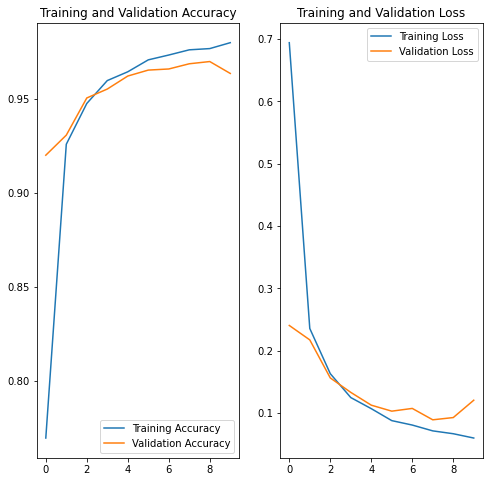

✅


In [23]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [24]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [25]:
results = model_wav.evaluate(test_dataset)
print("✅")

159/159 [==============================] - 24s 154ms/step - loss: 0.0889 - accuracy: 0.9686
✅


In [26]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.089
accuracy value: 96.8589%
✅


In [28]:
def spec2wav(stft):
    y = np.abs(librosa.istft(stft))
    return y

In [45]:
print(test_wav[0].shape)

(130, 126, 1)


In [47]:
data_wav = []
for spec in test_wav: # 변수명을 그대로 써서 test_wav에 spec_data의 10%가 들어있음
    wav = spec2wav(spec.reshape(130, 126))
    data_wav.append(wav)
    
data_wav = np.array(data_wav)
data_wav.shape

(5062, 8000)

In [52]:
import IPython.display as ipd
import random

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(data_wav), size=1, replace=False)

batch_xs = np.array(test_wav[batch_index]) ##########
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

# ipd.Audio(batch_xs.reshape(8000,), rate = 8000)
compare_xs = np.array(data_wav[batch_index])
ipd.Audio(compare_xs.reshape(8000, ), rate = 8000)

label :  up


In [51]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: down(Correct!)
✅


# 회고

### - 이번 프로젝트에서 어려웠던 점.
    CNN에 대한 명확한 개념이 잡혀있지 않아 모델을 2차원 데이터에 맞게 구성하는 것에 1차적으로 어려움을 겪었습니다. 처음에는 LMS 노드의 내용을 이해하기 위해 관련 내용들을 그대로 실습하는데 초점이 맞춰져서 Conv1D로 잘못 학습시키고 있던걸 혜림퍼실님께서 바로잡아주셨습니다.
    
    2번째로 어려웠던 점은 모델 구성 이후 testset에서까지 좋은 acc를 받은거 까지는 좋았는데, 제 귀로 직접 정답인지 체크해보고 싶어서 2차원의 spectrogram 파일들을 다시 1차원으로 변환하기 위한 spec2wav 함수를 정의하고, 변환 과정을 거처 다시 음성을 추출하는 과정에서 애를 먹었습니다. 결국 또 혜림퍼실님이 방법을 알려주셔서 어찌저찌 변환은 성공햇는데, 막상 들어보니 데이터가 많이 손실된 상태여서 label에 해당되는 음원을 명확하게 듣지는 못했습니다.


### - 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점.
    skip-connection 모델로 수행했을 때 성능이 크게 다르지 않다는 점을 알게되었습니다.
    spectrogram에서 wav 파일로 완벽하게 복구하는 것은 힘들지만, melspectrogram에서 wav 파일로 변환하면 크게 데이터의 손실 없이 변환하는 것이 가능하다는 것을 알게되었습니다.


### - 루브릭 평가 지표를 맞추기 위해 시도한 것들.
    
    1) 음성데이터를 2차원 Spectrogram으로 변환하여 데이터셋을 구성하였다. (스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상 진행되었는가?)
    
    네. 음성데이터(wav)를 2차원의 Spectrogram(spec)으로 변환해서 학습을 진행하였습니다.
    
    
    
    2) 1, 2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다. (스펙트로그램을 입력받은 모델이 학습 과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행 가능한가?)
    
    네. Conv2D 모델을 생성하여 2차원 데이터를 올바로 학습시켰고, loss와 acc를 출력해 그래프로 그려본 결과 loss가 0으로 수렴하고, 그에 따른 정확도도 향상되는 것을 확인하였습니다.
    
    
    
    3) 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다. (evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재하는가?)
    
    네. 학습된 모델을 바탕으로 테스트셋을 수행해본 결과 해당 모델의 acc가 96.86% 나오는 것을 확인하였습니다. 또한, skip-connection 모델로도 수행해보았는데, 해당 모델 역시 96.29%의 높은 정확도를 보이는 것을 확인하였습니다.
    
    
    